# 遗传算法

`2022-2-1 12:09:30`

遗传算法，直观理解就是将解空间的每个状态做一个二进制编号，通过生存函数只保留相对优秀的状态，然后用它们的二进制编号进行交配繁衍和变异（本质上是随机生成一部分和最优状态在二进制上比较相关的其他的零散的搜索空间）循环迭代，直到最后，淘汰剩下都都会是最优解（可能的话）

下面用正弦函数生成一个二维平面上的等高线地图，一共有120*120=14400个状态空间，用100个生物（假设是山羊）的群组，模拟洪水爆发的过程，让山羊爬到这片区域最高点的迭代过程

- 一定要将空间状态打乱后再编号（调试过好几个小时，发现不打乱的话，繁衍出来的后代会聚集到和实际理解不同的地方）

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import copy
warnings.simplefilter("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']   
plt.rcParams['axes.unicode_minus'] = False 

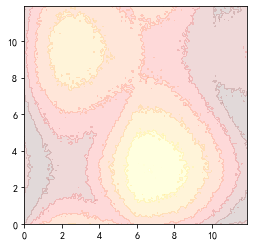

In [2]:
idx = np.arange(-0, 12, 0.1)
idy = np.arange(-0, 12, 0.1)
idxx, idyy = np.meshgrid(idx, idy)
x = np.c_[idxx.ravel(), idyy.ravel()]
z = abs(- (1.5 * np.sin(x[:, 0]**0.75) + 1.25 * np.cos(x[:, 1]**0.75+0.89) + np.random.randn(len(x)) / 10))
idzz = z.reshape(idxx.shape)

delta  = 25

for i in range(60):
    idzz[:, i] += i/delta
for i in range(119, 59, -1):
    idzz[:, i] += abs(120-i)/delta

# for i in range(60):
#     idzz[i, :] += i/delta
# for i in range(119, 59, -1):
#     idzz[i, :] += abs(120-i)/delta

# print(idzz.shape)

data = np.concatenate([x, z.reshape(-1, 1)], axis=1)
plt.figure(figsize=(4, 4))
plt.contourf(idxx, idyy, idzz, alpha=0.15, cmap=plt.cm.hot)
plt.show()

# 可达状态二进制编号

120*120 = 14400 个状态，用12位的二进制字符可以表示

In [3]:
# 给所有解空间一个编码
## 一定要先将样本的顺序打乱再编号，不然存在强相关性！！！
df = pd.DataFrame(data, columns=["x1", "x2", "z"])
df = df.sample(frac=1)
ids = np.arange(len(df))
bins = [('000000000000' + bin(i)[2:])[::-1][:12][::-1] for i in ids]
df["id"] = ids
df["bin"] = bins
df.head()

,x1,x2,z,id,bin
1445,0.5,1.2,0.417473,0,000000000000
11370,9.0,9.4,1.243592,1,000000000001
3023,2.3,2.5,1.121394,2,000000000010
6821,10.1,5.6,1.882506,3,000000000011
10338,1.8,8.6,3.365570,4,000000000100


# 建立 GA 类

In [4]:
class GA(object):
    def __init__(self, samples, nums=100):
        self.samples = copy.copy(samples)
        self.nums = nums
        self.colony = None 
        self.init_colony()
        self.colony_save = None
        self.pairs = None
        self.colony_child = None
        pass
    
    def run(self):
        # 淘汰生物群
        self.eliminate()
        # 幸存生物群体配对
        self.compair()
        # 繁衍，交换染色体，产生后代
        self.reproduction()
        # 后代取代前代
        self.colony = copy.copy(self.colony_child.iloc[:, :-1])
        pass
    
    def show(self):
        # print(self.samples)
        pass
    
    def init_colony(self):
        ls_id = list()
        for i in range(self.nums):
            candidate = [i for i in range(len(self.samples)) if i not in ls_id]
            tmp_id = np.random.choice(candidate)
            ls_id.append(tmp_id)
        mask = self.samples["id"].isin(ls_id)
        tmp_df = self.samples[mask]
        self.colony = copy.copy(tmp_df)
        # print(self.colony)
        pass
    
    def eliminate(self):
        # 每次只保留最优的10%个体
        tmp_colony = copy.copy(self.colony)
        tmp_nums = int(len(tmp_colony) // 10)
        # print(tmp_nums)
        tmp_colony.sort_values(by="z", ascending=False, inplace=True)
        self.colony_save = tmp_colony[:tmp_nums]
        pass
    
    def compair(self):
        bins = copy.copy(self.colony_save)["bin"].values.tolist()        
        tmp_pairs = list()
        for i in range(self.nums):
            tmp1 = np.random.choice(bins)
            tmp2 = np.random.choice(bins)
            tmp_pairs.append((tmp1, tmp2))
        self.pairs = tmp_pairs
        # print(self.pairs)
        pass
    
    def reproduction(self):
        datas = list()
        for pair in self.pairs:
            item1, item2 = pair
            while True:
                g_str = ""
                for i in range(len(pair[0])):
                    g = np.random.choice([item1[i], item2[i]])
                    if np.random.rand() >= 0.95: # 10% 的概率会产生基因变异
                        g = str((int(g)+1)%2)
                    g_str += g
                # 如果后代不在解空间，继续生，直到生出正常的后代
                if g_str in self.samples["bin"].values.tolist():
                    break
            mask = self.samples["bin"] == g_str
            data = self.samples[mask].values[0].tolist()
            data.append(pair)
            datas.append(data)
        cols = self.samples.columns.tolist()
        cols.append("pair")
        tmp_df = pd.DataFrame(datas, columns = cols)
        self.colony_child = tmp_df
        pass

# 训练和迭代

In [7]:
# 迭代一次产生的效果
ga = GA(df, nums=100)

ls_colony = list()
ls_colony_child = list()
ls_colony_save = list()

for i in range(10):
    ga.run()
    print(f"iter = {i}, run finished")
    ls_colony.append((i, ga.colony))
    ls_colony_save.append((i, ga.colony_save))
    ls_colony_child.append((i, ga.colony_child))

iter = 0, run finished
iter = 1, run finished
iter = 2, run finished
iter = 3, run finished
iter = 4, run finished
iter = 5, run finished
iter = 6, run finished
iter = 7, run finished
iter = 8, run finished
iter = 9, run finished


# 每次迭代后的最优个体

可以发现山羊们从分散聚集，慢慢往聚敛到同一个点（这就是最优解）

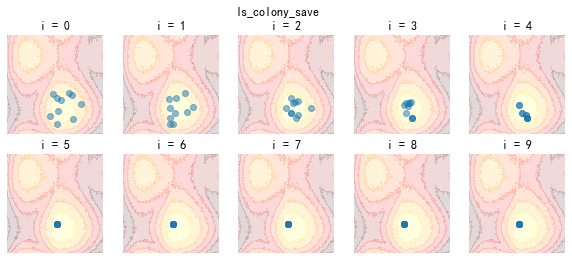

In [13]:
fig, axes = plt.subplots(2, 5)
fig.set_figheight(4)
fig.set_figwidth(10)
fig.suptitle("ls_colony_save")
for i in range(len(ls_colony_save)):
    ay = i%5 
    ax = i//5
    # print(i, ax, ay)
    axes[ax, ay].contourf(idxx, idyy, idzz, alpha=0.15, cmap=plt.cm.hot)
    axes[ax, ay].scatter(ls_colony_save[i][1]["x1"], ls_colony_save[i][1]["x2"], alpha=0.5)
    axes[ax, ay].set_axis_off()
    axes[ax, ay].set_title(f"i = {ls_colony_save[i][0]}")
plt.show()
# [i for i in dir(fig) if 'title' in i]

# 每次迭代产生的后代群

山羊们的后代，慢慢减少生出不好质量的孩子

- 第9幅图，除了最优点，其他点其实是在尝试性搜索有没有更优的后代会被生成

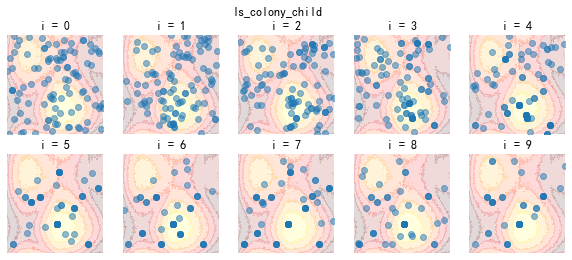

In [15]:
fig, axes = plt.subplots(2, 5)
fig.set_figheight(4)
fig.set_figwidth(10)
fig.suptitle("ls_colony_child")
for i in range(len(ls_colony_child)):
    ay = i%5 
    ax = i//5
    # print(i, ax, ay)
    axes[ax, ay].contourf(idxx, idyy, idzz, alpha=0.15, cmap=plt.cm.hot)
    axes[ax, ay].scatter(ls_colony_child[i][1]["x1"], ls_colony_child[i][1]["x2"], alpha=0.5)
    axes[ax, ay].set_axis_off()
    axes[ax, ay].set_title(f"i = {ls_colony_child[i][0]}")
plt.show()
# [i for i in dir(fig) if 'title' in i]